In [1]:
import pandas as pd

In [2]:

df = pd.read_excel('BCI backup.xlsx', sheet_name='Dummy leads')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Lead_ID                      20 non-null     object
 1   Booking_ID                   20 non-null     object
 2   Customer name                20 non-null     object
 3   Lead_Source                  20 non-null     object
 4   First_Time_Buyer             20 non-null     object
 5   Age                          20 non-null     int64 
 6   Gender                       20 non-null     object
 7   Location                     20 non-null     object
 8   Income                       20 non-null     int64 
 9   OEM_Loyalty_Program          20 non-null     object
 10  Finances_Status              20 non-null     object
 11  CIBIL_Score                  20 non-null     int64 
 12  Down_Payment                 20 non-null     int64 
 13  Undecided_Finances           20 non-n

In [3]:
df = df.fillna('None')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Lead_ID                      20 non-null     object
 1   Booking_ID                   20 non-null     object
 2   Customer name                20 non-null     object
 3   Lead_Source                  20 non-null     object
 4   First_Time_Buyer             20 non-null     object
 5   Age                          20 non-null     int64 
 6   Gender                       20 non-null     object
 7   Location                     20 non-null     object
 8   Income                       20 non-null     int64 
 9   OEM_Loyalty_Program          20 non-null     object
 10  Finances_Status              20 non-null     object
 11  CIBIL_Score                  20 non-null     int64 
 12  Down_Payment                 20 non-null     int64 
 13  Undecided_Finances           20 non-n

In [4]:
from rules import bci_rules, evaluate_condition

def addTargetValue(row):
    counts = 0
    for i in range(len(bci_rules)):
        if evaluate_condition(row[bci_rules[i]['value']], bci_rules[i]["condition"]):
            counts += 1
    if counts >= 10:
        return 1
    return 0

df['bciindex'] = df.apply(lambda row: addTargetValue(row), axis=1)
print(df['bciindex'].value_counts())
print(df['bciindex'].head())

bciindex
0    15
1     5
Name: count, dtype: int64
0    1
1    0
2    0
3    0
4    0
Name: bciindex, dtype: int64


In [5]:
def checkRows(row):
    row['Booking_Lead_Time'] = int(row['Booking_Lead_Time'].replace(' days', ''))
    row['Add_Ons'] = len(row['Add_Ons'].replace(' ', '').split(';'))
    return row

df = df.apply(checkRows, axis=1)
print(df['Add_Ons'].head())
df_filtered = df.select_dtypes(include=['int64', 'float64', 'datetime64[ns]'])
print(df_filtered.columns)

0    2
1    1
2    1
3    1
4    1
Name: Add_Ons, dtype: int64
Index(['Age', 'Income', 'CIBIL_Score', 'Down_Payment', 'Booking_Lead_Time',
       'Add_Ons', 'Customer_Satisfaction_Score', 'bciindex'],
      dtype='object')


In [6]:
age_labels = ['KID', 'YOUNG', 'OLD']
df['Age'] = pd.cut(df['Age'], bins=3, labels=age_labels)
df['Age'].head()

0      KID
1    YOUNG
2      OLD
3      KID
4      OLD
Name: Age, dtype: category
Categories (3, object): ['KID' < 'YOUNG' < 'OLD']

In [7]:
other_labels = ['LOW', 'MEDIUM', 'HIGH']
df_filtered = df_filtered.drop(['Age', 'bciindex'], axis=1)
for i in df_filtered.columns:
    df[i] = pd.cut(df[i], bins=3, labels=other_labels)
# df[df_filtered.columns] = pd.cut(df[df_filtered.columns], bins=3, labels=other_labels)
df[df_filtered.columns].head()

,Income,CIBIL_Score,Down_Payment,Booking_Lead_Time,Add_Ons,Customer_Satisfaction_Score
0,MEDIUM,MEDIUM,LOW,LOW,HIGH,HIGH
1,HIGH,HIGH,HIGH,MEDIUM,LOW,MEDIUM
2,MEDIUM,LOW,LOW,LOW,LOW,LOW
3,LOW,LOW,LOW,LOW,LOW,HIGH
4,HIGH,HIGH,HIGH,HIGH,LOW,HIGH


In [8]:
df.describe()

,bciindex
count,20.000000
mean,0.250000
std,0.444262
min,0.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,1.000000


In [9]:
# from scipy import stats

# first_time_buyers = df[df['First_Time_Buyer'] == 'Yes']['Customer_Satisfaction_Score']
# repeat_customers = df[df['First_Time_Buyer'] == 'No']['Customer_Satisfaction_Score']

# t_statistic, p_value = stats.ttest_ind(first_time_buyers, repeat_customers)

# print(f"T-statistic: {t_statistic}, P-value: {p_value}")

In [10]:
# Drop Unwanted 
unwanted_columns = ['Lead_ID', 'Booking_ID', 'Customer name', 'Location']
df = df.drop(unwanted_columns, axis=1)


In [11]:
df_filtered = df.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
filtered_columns = [f'C({item})' for item in df_filtered.columns]
logit_formula = 'bciindex ~ ' + ' + '.join(filtered_columns)
print(logit_formula)

bciindex ~ C(Lead_Source) + C(First_Time_Buyer) + C(Age) + C(Gender) + C(Income) + C(OEM_Loyalty_Program) + C(Finances_Status) + C(CIBIL_Score) + C(Down_Payment) + C(Undecided_Finances) + C(Special_Occasions) + C(Booking_Lead_Time) + C(Needs_Match) + C(Add_Ons) + C(Dealership_Engagement) + C(Experience_With_Sales_Rep) + C(Companion_Feedback) + C(Stock_Status) + C(Delivery_Date_Status) + C(Competitive_Factors) + C(External_Factors) + C(Customer_Satisfaction_Score) + C(Cancellation_Probability) + C(Vehicle_Type) + C(Test_Drive_Status) + C(Preferred_Delivery_Time)


In [12]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2_stat, p_value, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    phi2 = chi2_stat / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

new_df = df.copy()
new_df[df_filtered.columns] = new_df[df_filtered.columns].apply(lambda x: x.astype('category'))
# sample_df = new_df.sample(frac=0.03, random_state=42)
column_names = df_filtered.columns[2:3]
data = pd.crosstab(new_df['bciindex'], [new_df[col] for col in column_names])
v = cramers_v(data.values)
# print(data.describe())
chi2, p, dof, expected = chi2_contingency(data)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:", expected)

if p < 0.05:
    print("You don't have to remove that features")
else:
    print("You can remove that features" , column_names)

if v > 0.5:
    print('You need to remove features as per Cramer_v as well')

Chi-Square Statistic: 3.4814814814814814
P-value: 0.17539043364728615
Degrees of Freedom: 2
Expected Frequencies: [[6.75 6.   2.25]
 [2.25 2.   0.75]]
You can remove that features Index(['Age'], dtype='object')


In [13]:
# from imblearn.over_sampling import SMOTENC
# categorical_columns = df.drop(['bciindex'], axis=1)
# data_encoded = pd.get_dummies(df, columns=categorical_columns.columns, drop_first=True)
# # corr_matrix = data_encoded.corr()

# X = data_encoded.drop('bciindex', axis=1)
# y = data_encoded['bciindex']

# # List of indices of categorical columns in your dataset
# categorical_features_indices = [i for i, col in enumerate(X.columns) if col in categorical_columns]

# # Apply SMOTENC
# smote = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [14]:
import statsmodels.api as sm
sm.add_constant(df[df_filtered.columns])
logit_model = sm.Logit.from_formula(logit_formula , df)
# weights = y.apply(lambda x: 1 if x == 1 else 0.5)
fitted_model = logit_model.fit(method='cg', skip_hessian=False)
print(fitted_model.summary())

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 20
         Function evaluations: 90
         Gradient evaluations: 90
                           Logit Regression Results                           
Dep. Variable:               bciindex   No. Observations:                   20
Model:                          Logit   Df Residuals:                        1
Method:                           MLE   Df Model:                           18
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                   1.000
Time:                        17:06:09   Log-Likelihood:            -0.00024012
converged:                       True   LL-Null:                       -11.247
Covariance Type:            nonrobust   LLR p-value:                    0.2108
                                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


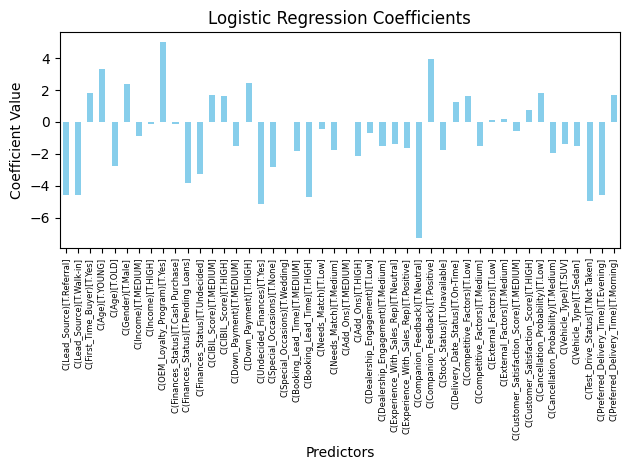

In [15]:
import matplotlib.pyplot as plt
coefficients = fitted_model.params

coefficients.drop('Intercept').plot(kind='bar', color='skyblue')

plt.title('Logistic Regression Coefficients')
plt.xlabel('Predictors')
plt.ylabel('Coefficient Value')
plt.xticks(fontsize=6)

plt.tight_layout()
# Display the plot
plt.show()

In [16]:
import dalex as dx

X= new_df.drop('bciindex', axis=1)
y = new_df['bciindex']
df_index = pd.read_excel('BCI backup.xlsx', sheet_name='Dummy leads')
exp = dx.Explainer(fitted_model, X, y)

for i in range(len(X)):
    # Get feature importance
    breakdown = exp.predict_parts(X.iloc[i], type='break_down', label=X.index[0])
    breakdown.plot(title=df_index.iloc[i]['Customer name'])
# sh_mary = exp.predict_parts(X.iloc[1], type='shap', B=10, label=X.index[0])

Preparation of a new explainer is initiated

  -> data              : 20 rows 26 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 20 values
  -> model_class       : statsmodels.discrete.discrete_model.BinaryResultsWrapper (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x0000028CBF598C20> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 6.83e-17, mean = 0.25, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.75e-05, mean = 1.12e-06, max = 4.03e-05
  -> model_info        : package statsmodels

A new explainer has been created!


c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\dalex\_explainer\object.py:138: UserWarning: 
  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)
  checks.check_predict_function_and_model_type(predict_function, model_type,


In [17]:
df_customer_formula = "bciindex ~ C(Lead_Source) + C(First_Time_Buyer) + C(Age) + C(Gender) + C(Income) + C(OEM_Loyalty_Program)"
df_finances_formula = "bciindex ~ C(Finances_Status) + C(CIBIL_Score) + C(Down_Payment) + C(Undecided_Finances)"
df_bookingdetails_formula = "bciindex ~ C(Special_Occasions) + C(Booking_Lead_Time) + C(Needs_Match) + C(Add_Ons)"
df_deliverydetails_formula = "bciindex ~ C(Dealership_Engagement) + C(Experience_With_Sales_Rep) + C(Companion_Feedback) + C(Stock_Status) + C(Delivery_Date_Status)"
df_customerexperience_formula = "bciindex ~ C(Competitive_Factors) + C(External_Factors) + C(Customer_Satisfaction_Score) + C(Cancellation_Probability) + C(Vehicle_Type) + C(Test_Drive_Status) + C(Preferred_Delivery_Time)"

In [18]:
df_customermodel = sm.Logit.from_formula(df_customer_formula , df).fit(method='cg', skip_hessian=False)
df_financesmodel = sm.Logit.from_formula(df_finances_formula , df).fit(method='cg', skip_hessian=False)
df_bookingdetailsmodel = sm.Logit.from_formula(df_bookingdetails_formula , df).fit(method='cg', skip_hessian=False)
df_deliverydetailsmodel = sm.Logit.from_formula(df_deliverydetails_formula , df).fit(method='cg', skip_hessian=False)
df_customerexperiencemodel = sm.Logit.from_formula(df_customerexperience_formula , df).fit(method='cg', skip_hessian=False)


Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 17
         Function evaluations: 79
         Gradient evaluations: 79
         Current function value: 0.192593
         Iterations: 35
         Function evaluations: 114
         Gradient evaluations: 114
         Current function value: 0.208234
         Iterations: 35
         Function evaluations: 123
         Gradient evaluations: 123
         Current function value: 0.095745
         Iterations: 35
         Function evaluations: 114
         Gradient evaluations: 114
         Current function value: 0.000469
         Iterations: 35
         Function evaluations: 137
         Gradient evaluations: 137


c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\scipy\optimize\_optimize.py:1658: OptimizeWarning:

Maximum number of iterations has been exceeded.

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\scipy\optimize\_optimize.py:1658: OptimizeWarning:

Maximum number of iterations has been exceeded.

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check 

In [19]:
print(df_customermodel.summary())

                           Logit Regression Results                           
Dep. Variable:               bciindex   No. Observations:                   20
Model:                          Logit   Df Residuals:                       10
Method:                           MLE   Df Model:                            9
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                  0.9999
Time:                        17:06:23   Log-Likelihood:            -0.00091087
converged:                       True   LL-Null:                       -11.247
Covariance Type:            nonrobust   LLR p-value:                  0.007445
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -19.6401    121.488     -0.162      0.872    -257.752     218.471
C(Lead_Source)[T.Referral]      -18.5623    242.318     -0.077      0.939 

In [20]:
print(df_financesmodel.summary())


                           Logit Regression Results                           
Dep. Variable:               bciindex   No. Observations:                   20
Model:                          Logit   Df Residuals:                       11
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                  0.6575
Time:                        17:06:23   Log-Likelihood:                -3.8519
converged:                      False   LL-Null:                       -11.247
Covariance Type:            nonrobust   LLR p-value:                   0.06337
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -1.4062     58.154     -0.024      0.981    -115.386     112.574
C(Finances_Status)[T.Cash Purchase]   -11.4184     21.50

In [21]:
print(df_bookingdetailsmodel.summary())

                           Logit Regression Results                           
Dep. Variable:               bciindex   No. Observations:                   20
Model:                          Logit   Df Residuals:                       12
Method:                           MLE   Df Model:                            7
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                  0.6297
Time:                        17:06:23   Log-Likelihood:                -4.1647
converged:                      False   LL-Null:                       -11.247
Covariance Type:            nonrobust   LLR p-value:                   0.04834
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.0282        nan        nan        nan         nan         nan
C(Special_Occasions)[T.None]       -4.9103        nan        nan    

In [22]:
df_bookingdetailsmodelGLM = sm.GLM.from_formula(
    df_bookingdetails_formula, df, family=sm.families.Binomial()
).fit(attach_wls=True, atol=1e-10)
print(df_bookingdetailsmodelGLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               bciindex   No. Observations:                   20
Model:                            GLM   Df Residuals:                       12
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.1589
Date:                Mon, 24 Feb 2025   Deviance:                       8.3178
Time:                        17:06:23   Pearson chi2:                     6.00
No. Iterations:                    26   Pseudo R-squ. (CS):             0.5078
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [23]:
import re
from lightgbm import Dataset, train
df_bookinglightbm = X[re.findall(r'C\((.*?)\)', df_bookingdetails_formula)]
convert_dict = {
    "Special_Occasions": "category",
    "Booking_Lead_Time": "category",
    "Needs_Match": "category",
    "Add_Ons": "category",
}
df_bookinglightbm = df_bookinglightbm.astype(convert_dict)
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
params_lgbm = {
    "objective": "binary",
    "metric": "auc",
    "scale_pos_weight": scale_pos_weight,
    "learning_rate": 0.01,
    "subsample": 0.9,
    "feature_fraction": 0.9,
    "num_boost_round": 1,
    "random_state": 42,
    "verbosity":0,
    "max_cat_threshold": 3
}
lgbmtraindataset = Dataset(df_bookinglightbm, label=y)
lgbmtestdataset = Dataset(df_bookinglightbm, label=y)
# lgbmevals = [lgbmtraindataset, lgbmtestdataset]
lgbmmodel = train(
    params=params_lgbm,
    train_set=lgbmtraindataset,
    # num_boost_round=500,
    # valid_sets=lgbmevals,
    # valid_names=["train", "valid"]
)
y_probs = lgbmmodel.predict(df_bookinglightbm)
probs = [float(value) * 100 for value in y_probs]
print(probs)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]


In [24]:
print(df_deliverydetailsmodel.summary())

                           Logit Regression Results                           
Dep. Variable:               bciindex   No. Observations:                   20
Model:                          Logit   Df Residuals:                       11
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                  0.8297
Time:                        17:06:24   Log-Likelihood:                -1.9149
converged:                      False   LL-Null:                       -11.247
Covariance Type:            nonrobust   LLR p-value:                   0.01677
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  -11.1659   1.74e+07  -6.41e-07      1.000   -3.41e+07    3.41e+07
C(Dealership_Engagement)[T.Low]          

In [25]:
print(df_customerexperiencemodel.summary())

                           Logit Regression Results                           
Dep. Variable:               bciindex   No. Observations:                   20
Model:                          Logit   Df Residuals:                        8
Method:                           MLE   Df Model:                           11
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                  0.9992
Time:                        17:06:24   Log-Likelihood:             -0.0093740
converged:                      False   LL-Null:                       -11.247
Covariance Type:            nonrobust   LLR p-value:                   0.02094
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -2.8789        nan        nan        nan         nan         nan
C(Competitive_Factors)[T.Low]            

In [26]:
import re
df_Customerprofile = X[re.findall(r'C\((.*?)\)', df_customer_formula)]
df_Finance = X[re.findall(r'C\((.*?)\)', df_finances_formula)]
df_Bookingdetails = X[re.findall(r'C\((.*?)\)', df_bookingdetails_formula)]
df_deliveryDetails = X[re.findall(r'C\((.*?)\)', df_deliverydetails_formula)]
df_customerexperience = X[re.findall(r'C\((.*?)\)', df_customerexperience_formula)]

In [27]:
exp1 = dx.Explainer(df_customermodel, df_Customerprofile, y)
exp2 = dx.Explainer(df_financesmodel, df_Finance, y)
exp3 = dx.Explainer(df_bookingdetailsmodel, df_Bookingdetails, y)
exp4 = dx.Explainer(df_deliverydetailsmodel, df_deliveryDetails, y)
exp5 = dx.Explainer(df_customerexperiencemodel, df_customerexperience, y)

Preparation of a new explainer is initiated

  -> data              : 20 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 20 values
  -> model_class       : statsmodels.discrete.discrete_model.BinaryResultsWrapper (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x0000028CBF598C20> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 9.7e-14, mean = 0.25, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.000277, mean = -8.19e-06, max = 0.000113
  -> model_info        : package statsmodels

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 20 rows 4 cols
 

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)

c:\Users\mukulkathuria\Documents\mlprac\driveai\bciindexanalysis\bcienv\Lib\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predic

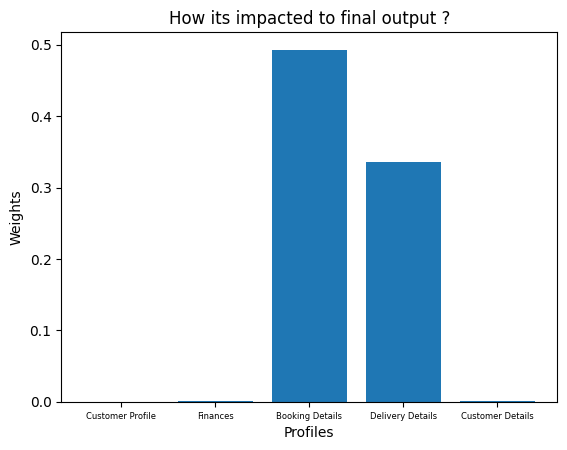

Final Prbability:  16.59


In [28]:


def getValuesofCustomer(person):
    index = np.where(df_index['Customer name'] == person)[0][0]
    to_predicted = new_df.iloc[int(index)]

    model1values = to_predicted[df_Customerprofile.columns]
    breakdown = exp1.predict_parts(to_predicted[df_Customerprofile.columns], type='break_down', label='Customer Profile')
    breakdown.plot(title=person)

    model2values = to_predicted[df_Finance.columns]
    breakdown = exp2.predict_parts(to_predicted[df_Finance.columns], type='break_down', label='Finances')
    breakdown.plot(title=person)

    model3values = to_predicted[df_Bookingdetails.columns]
   
    breakdown = exp3.predict_parts(to_predicted[df_Bookingdetails.columns], type='break_down', label='Booking Details')
    breakdown.plot(title=person)

    model4values = to_predicted[df_deliveryDetails.columns]
   
    breakdown = exp4.predict_parts(to_predicted[df_deliveryDetails.columns], type='break_down', label='Delivery Details')
    breakdown.plot(title=person)

    model5values = to_predicted[df_customerexperience.columns]
   
    breakdown = exp5.predict_parts(to_predicted[df_customerexperience.columns], type='break_down', label='Customer Details')
    breakdown.plot(title=person)

    model1_predicted = df_customermodel.predict(model1values).to_numpy()[0]
    model2_predicted = df_financesmodel.predict(model2values).to_numpy()[0]
    model3_predicted = df_bookingdetailsmodel.predict(model3values).to_numpy()[0]
    model4_predicted = df_deliverydetailsmodel.predict(model4values).to_numpy()[0]
    model5_predicted = df_customerexperiencemodel.predict(model5values).to_numpy()[0]
    finalresult  = model1_predicted + model2_predicted + model3_predicted + model4_predicted + model5_predicted
    bar_labels = ['Customer Profile', 'Finances', 'Booking Details', 'Delivery Details','Customer Details']
    bar_values = [model1_predicted,model2_predicted,model3_predicted,model4_predicted,model5_predicted]
    plt.bar(bar_labels, bar_values)
    plt.title('How its impacted to final output ?')
    plt.xlabel('Profiles')
    plt.ylabel('Weights')
    plt.xticks(fontsize=6)
    plt.show()
    return round((finalresult * 100) / 5,2)

print("Final Prbability: ", getValuesofCustomer('Ramesh Choudhary'))

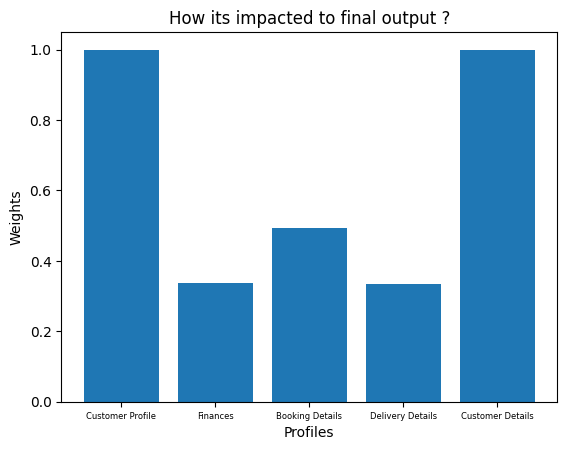

Final Prbability:  63.26


In [29]:
print("Final Prbability: ", getValuesofCustomer('Rahul Desai'))

In [30]:
df_filtered = df.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
filtered_columns = [f'C({item})' for item in df_filtered.columns]
logit_formula = 'bciindex ~ ' + ' + '.join(filtered_columns)
print(logit_formula)

bciindex ~ C(Lead_Source) + C(First_Time_Buyer) + C(Age) + C(Gender) + C(Income) + C(OEM_Loyalty_Program) + C(Finances_Status) + C(CIBIL_Score) + C(Down_Payment) + C(Undecided_Finances) + C(Special_Occasions) + C(Booking_Lead_Time) + C(Needs_Match) + C(Add_Ons) + C(Dealership_Engagement) + C(Experience_With_Sales_Rep) + C(Companion_Feedback) + C(Stock_Status) + C(Delivery_Date_Status) + C(Competitive_Factors) + C(External_Factors) + C(Customer_Satisfaction_Score) + C(Cancellation_Probability) + C(Vehicle_Type) + C(Test_Drive_Status) + C(Preferred_Delivery_Time)


In [31]:
df_customermodel.save('customermodel.pkl')
df_financesmodel.save('financesmodel.pkl')
df_bookingdetailsmodel.save('bookingdetailsmodel.pkl')
df_deliverydetailsmodel.save('deliverydetailsmodel.pkl')
df_customerexperiencemodel.save('customerexperiencemodel.pkl')

In [38]:
from dill import dump
# with open('financesexplainer.pkl', 'wb') as f:
#     dump(exp2, f)
# with open('bookingdetailsexplainer.pkl', 'wb') as f:
#     dump(exp3, f)
# with open('deliverydetailsexplainer.pkl', 'wb') as f:
#     dump(exp4, f)
# with open('customerexperienceexplainer.pkl', 'wb') as f:
#     dump(exp5, f)

In [ ]:
from joblib import load
to_predicted = new_df.iloc[0]
model1values = to_predicted[df_Customerprofile.columns]
df_customermodel2 = load('customermodel.pkl')
predictedcustomer = df_customermodel2.predict(model1values).to_numpy()[0]
breakdown = exp1.predict_parts(to_predicted[df_Customerprofile.columns], type='break_down', label='Customer Profile')
breakdown.plot(title='Aditi Joshi')